In [23]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
import geopandas as gpd
import shapely
from shapely.ops import split, GeometryCollection, Point,MultiPoint,LineString
import pandas as pd
import os
from pyproj import Transformer
import shutil

In [24]:
root_name = 'Austria'

In [25]:
dir_list = [os.listdir(root_name)[0]]

In [26]:
name = dir_list[0]
print(name)

Red Bull Ring


In [27]:
root = os.path.join(root_name, name) + os.sep
boundaries = gpd.read_file(root+r'boundaries.shp').to_crs(epsg=3857)

In [28]:
boundaries.length

0       3.217708
1    6290.010450
2    6401.346739
3     170.547997
4       0.070254
5       0.000000
6       0.135383
7      87.976877
8     217.111550
dtype: float64

In [29]:
def is_clockwise(coords):
    """Determines if a set of coordinates are ordered clockwise or counterclockwise."""
    area = 0
    n = len(coords)
    
    for i in range(n):
        x1, y1 = coords[i]
        x2, y2 = coords[(i + 1) % n]  # Next vertex (looping back to the first)
        area += (x2 - x1) * (y2 + y1)
    
    # print(area)
    return area > 0  # True if clockwise, False if counterclockwise

def cross_product_orientation(p1, p2, p3):
    """Computes the cross product of vectors (p1 -> p2) and (p2 -> p3)."""
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    return (x2 - x1) * (y3 - y2) - (y2 - y1) * (x3 - x2)


In [30]:
# dir = input('Enter the direction of the boundary (clockwise 0/counterclockwise 1): ')


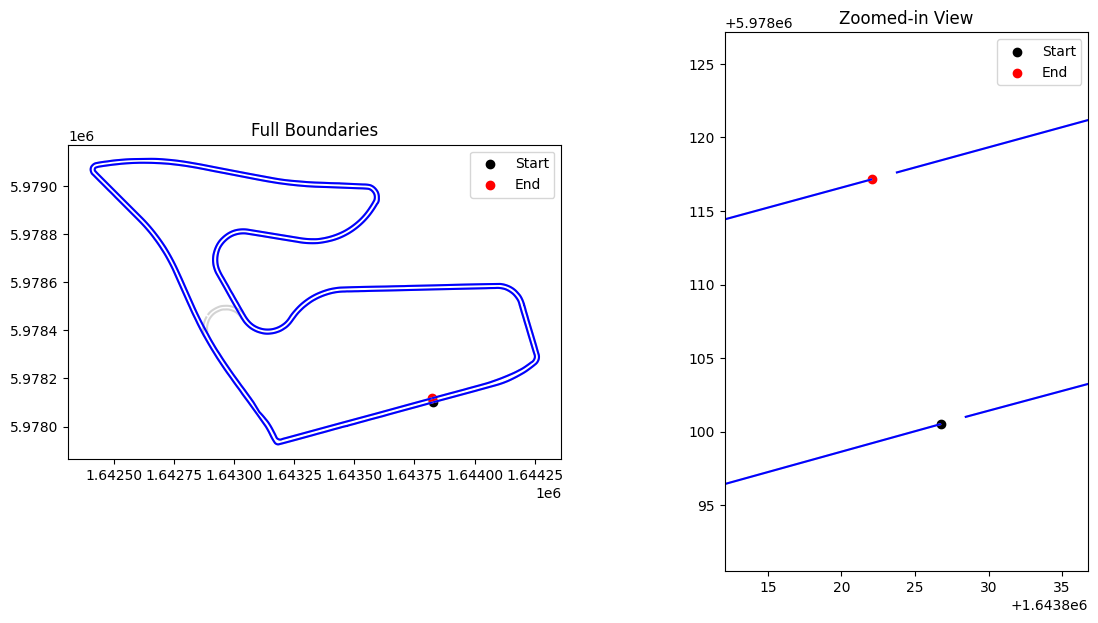

In [31]:
import matplotlib.pyplot as plt

# Define the ends and geometry for plotting
dir = 0
ends = [1, 2]
line1 = boundaries.iloc[ends[0]].geometry
line2 = boundaries.iloc[ends[1]].geometry

if dir == 0:
    if is_clockwise([i for i in line1.coords]) == False:
        line1 = line1.reverse()
    if is_clockwise([i for i in line2.coords]) == False:
        line2 = line2.reverse() 

    if line1.length < line2.length:
        temp = line1  # Outer boundary
        line1 = line2  # Inner boundary
        line2 = temp  # Swap the lines
elif dir == 1:
    if is_clockwise([i for i in line1.coords]) == True:
        line1 = line1.reverse()
    if is_clockwise([i for i in line2.coords]) == True:
        line2 = line2.reverse()

    if line1.length > line2.length:
        temp = line1
        line1 = line2
        line2 = temp
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the full boundaries on ax1
boundaries.plot(ax=ax1, color='lightgrey')
boundaries.iloc[ends].plot(ax=ax1, color='blue')  # Highlight selected boundaries
ax1.set_title('Full Boundaries')
ax1.scatter(line1.coords[0][0], line1.coords[0][1], color='black', label='Start')
ax1.scatter(line2.coords[0][0], line2.coords[0][1], color='red', label='End')
ax1.legend()

# Plot the zoomed-in view on ax2
boundaries.plot(ax=ax2, color='lightgrey')
boundaries.iloc[ends].plot(ax=ax2, color='blue')  # Highlight selected boundaries
ax2.set_title('Zoomed-in View')
ax2.scatter(line1.coords[0][0], line1.coords[0][1], color='black', label='Start')
ax2.scatter(line2.coords[0][0], line2.coords[0][1], color='red', label='End')

# Define zoomed limits based on the line coordinates
x_min = min(line1.coords[0][0], line2.coords[0][0]) - 10
x_max = max(line1.coords[0][0], line2.coords[0][0]) + 10
y_min = min(line1.coords[0][1], line2.coords[0][1]) - 10
y_max = max(line1.coords[0][1], line2.coords[0][1]) + 10
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.legend()

# Show the plot
plt.show()


In [32]:
total_points = int(boundaries.iloc[ends[0]].geometry.length/1.8)

In [33]:
inter_bounds= []
for line in [line1,line2]:
    distance_per_point = 2  # meters

    # Calculate the total length of the specified line
    total_length = line.length

    # Calculate the number of points based on the desired distance
    num_points = int(total_length // distance_per_point)

    # Generate interpolated points at 2-meter intervals
    interpolated_points = [line.interpolate(i * distance_per_point).xy for i in range(num_points + 1)]
    inter_bounds.append(interpolated_points)

In [34]:
new_inter_bounds=[]
for bound in inter_bounds:
    new_bound = []
    for x,y in bound:
        new_bound.append([x[0],y[0]])
    new_inter_bounds.append(new_bound)

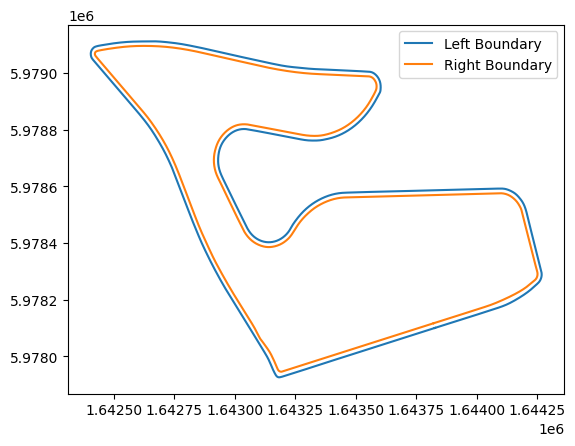

In [35]:
import numpy as np
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# Input points (convert the coordinates into numpy arrays for left and right boundaries)
# left_boundary = np.array([(x,y) for x,y in zip(left_x,left_y)])  # Add all your points here
# right_boundary = np.array([(x,y) for x,y in zip(right_x,right_y)])


# Apply spline interpolation to smooth the boundaries with periodic boundary condition
def smooth_boundary(boundary, is_periodic=True):
    x, y = boundary[:, 0], boundary[:, 1]
    
    # Apply periodic spline if the boundary is circular
    if is_periodic:
        tck, u = splprep([x, y], s=10, per=True)  # Set `per=True` to ensure it's periodic
    else:
        tck, u = splprep([x, y], s=10)  # Without periodicity
    
    x_smooth, y_smooth = splev(np.linspace(0, 1, total_points), tck)
    return x_smooth, y_smooth

# Smooth both left and right circular boundaries
left_x_smooth, left_y_smooth = smooth_boundary(np.array(new_inter_bounds[0]), is_periodic=True)
right_x_smooth, right_y_smooth = smooth_boundary(np.array(new_inter_bounds[1]), is_periodic=True)

# Plot the smoothed boundaries for visualization
plt.plot(left_x_smooth, left_y_smooth, label='Left Boundary')
plt.plot(right_x_smooth, right_y_smooth, label='Right Boundary')
plt.legend()
plt.show()


In [36]:
smoothed_left_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(left_x_smooth,left_y_smooth)],crs='EPSG:3857')
smoothed_right_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(right_x_smooth,right_y_smooth)],crs='EPSG:3857')
# smoothed_left_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(left_x,left_y)],crs='EPSG:3857').to_crs(epsg=4326)
# smoothed_right_boundary = gpd.GeoDataFrame(geometry= [Point(x,y) for x,y in zip(right_x,right_y)],crs='EPSG:3857').to_crs(epsg=4326)

final_smoothed_points= pd.DataFrame(data={'left_boundary':smoothed_left_boundary['geometry'].tolist(),'right_boundary':smoothed_right_boundary['geometry'].tolist()})

# def calc_mid(left,right):
#     x_mid = (left.x+right.x)/2
#     y_mid = (left.y+right.y)/2

#     return Point(x_mid, y_mid)  

# final_smoothed_points['mid_point']= final_smoothed_points.apply(lambda row: calc_mid(row['left_boundary'],row['right_boundary']),axis=1)

for col in final_smoothed_points.columns:
    final_smoothed_points[col+'_x']= final_smoothed_points[col].apply(lambda x: x.x)
    final_smoothed_points[col+'_y']= final_smoothed_points[col].apply(lambda x: x.y)

final_smoothed_points.drop(columns=['left_boundary', 'right_boundary'],inplace=True)
# points_gdf = gpd.GeoDataFrame(geometry=points)



In [37]:
def change_crs(df):
    # Transformer for EPSG 4326 to EPSG 3857
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

    # Function to apply transformation
    def transform_coords(x, y):
        return transformer.transform(x, y)

    # Apply transformation to the columns
    df[['left_boundary_x', 'left_boundary_y']] = df.apply(lambda row: transform_coords(row['left_boundary_x'], row['left_boundary_y']), axis=1, result_type='expand')
    df[['right_boundary_x', 'right_boundary_y']] = df.apply(lambda row: transform_coords(row['right_boundary_x'], row['right_boundary_y']), axis=1, result_type='expand')
    # df[['mid_point_x', 'mid_point_y']] = df.apply(lambda row: transform_coords(row['mid_point_x'], row['mid_point_y']), axis=1, result_type='expand')

    return df

final_smoothed_points = change_crs(final_smoothed_points)

maper = {
    'left_boundary_x':'left_long',
    'left_boundary_y':'left_lat',
    'right_boundary_x':'right_long',
    'right_boundary_y':'right_lat',
    }

final_smoothed_points.rename(columns=maper,inplace=True)

In [38]:
put = input('Track Name')
if dir == 0:
    put = 'CW_' + put
elif dir == 1:  
    put = 'CCW_' + put  
final_smoothed_points.to_csv(root+put+'.csv')
print(put)

CW_


In [ ]:
for dir in os.listdir(root_name):
    print(dir)
    if dir.split('.')[2] == 'png':
        dir_path = os.path.join(root_name, dir)
        country_path = os.path.join(root_name, dir.split('_')[4])
        os.makedirs(country_path, exist_ok=True)
        # print(dir.split('_')[4])
        track_path = os.path.join(country_path, dir.split('_')[5])
        os.makedirs(track_path, exist_ok=True)
        destination_path = os.path.join(track_path, dir)
        shutil.move(dir_path, destination_path)
        print(f"Moved {dir} to {destination_path}")
        # break
        # shutil.move(dir, dir.split('_')[4] + '/' + dir)

In [23]:
root_name_results = 'New_Tracks_Europe_results'
if not os.path.exists(root_name_results):
    os.makedirs(root_name_results)

In [24]:
dir_list

['Nelson Ledges']

In [25]:
import shutil
for i in dir_list:
    pth = os.path.join(root_name,i)
    for j in os.listdir(pth):
        if j.split('.')[-1]=='csv':
            src_path = os.path.join(pth,j)
            save_pth = os.path.join(root_name_results,i+'_'+j)
            # print(src_path)
            shutil.copy(src_path,save_pth)

In [21]:
import py3dep
import rasterio
import rasterio
import requests
from shapely.geometry import box
import geopandas as gpd
import os
import pandas as pd

In [251]:


# root= 'Selected tracks\\Atlanta Motorsports Park\\'
# Step 1: Open the raster file and get the bounds
for fol in dir_list:
    root = os.path.join(root_name,fol)
    raster_path = fol+'.tif'
    pth= os.path.join(root,raster_path)
    with rasterio.open(pth) as src:
        bounds = src.bounds  # Get bounds of the raster (left, bottom, right, top)

    # Convert bounds to shapely box for easy manipulation
    bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)


    # Convert bbox to GeoDataFrame for convenient CRS handling
    gdf = gpd.GeoDataFrame({"geometry": [bbox]}, crs=src.crs)

    gdf = gdf.to_crs(4326)

    bottom = gdf.total_bounds[1]-0.001
    top = gdf.total_bounds[3]+0.001
    left = gdf.total_bounds[0]-0.001
    right = gdf.total_bounds[2]+0.001

    bbox = gdf.total_bounds.tolist()
    print(root)
    print(top,bottom,left,right)

    url = f"https://portal.opentopography.org/API/globaldem?demtype=NASADEM&south={bottom}&north={top}&west={left}&east={right}&outputFormat=GTiff&API_Key=a2af117fe2f2c222b60773e796fc3b2d"

    # Request the DEM
    response = requests.get(url)

    # Save the file
    if response.status_code == 200:
        with open(root + "//30_m.tif", "wb") as file:
            file.write(response.content)
            print("DEM downloaded successfully!")
    else:
        print("Failed to download DEM.")


New_Tracks_Europe\Circuit de Barcelona-Catalunya
41.576699999999974 41.56250000000001 2.2499999999999996 2.2657
DEM downloaded successfully!


In [252]:
for fol in dir_list:
    root = os.path.join(root_name,fol)
    raster_path = '30_m.tif'
    pth= os.path.join(root,raster_path)
    with rasterio.open(pth) as src:
        # Read the raster data
        img = src.read(1).astype(np.float32) 
        # Get the affine transform coefficients
        transform = src.transform
        # Get the coordinate reference system
        crs = src.crs  

    # Resize the image using OpenCV
    scale_factor = 15
    binary_image = cv2.resize(img, (img.shape[1] * scale_factor, img.shape[0] * scale_factor), interpolation=cv2.INTER_CUBIC).astype(np.float32)

    # Calculate the new transform to maintain the spatial extent
    new_transform = transform * transform.scale(
        1 / scale_factor, 1 / scale_factor
    )
    with rasterio.open(
        os.path.join(root,'new_30_m.tif'),
        'w',
        driver='GTiff',
        height=binary_image.shape[0],
        width=binary_image.shape[1],
        count=1,  # Single band for the binary image
        dtype=binary_image.dtype,
        crs=src.crs,
        transform=new_transform,
    ) as dst:
        dst.write(binary_image, 1)

    print("Binary image saved as 'binary_output.tif'")

Binary image saved as 'binary_output.tif'


In [22]:
def get_elevation(dem, x, y):
    # Convert (x, y) coordinates to the raster's row and column
    row, col = dem.index(x, y)
    # Read the elevation value at that row and column
    elevation = dem.read(1)[row, col]
    return elevation

In [27]:
import os
import pandas as pd

root_elevation = 'New_Tracks_Europe_Elevation_Interpolated'
dem_name = '30_m.tif'
for file in os.listdir(root_name_results):
    folder = file.split('_')[0]

    root = os.path.join(root_name,folder)
    dem_type = ''
    for next_file in os.listdir(root):
        if next_file==dem_name:
            dem_type = next_file
    dem_pth = os.path.join(root,dem_type)
    print(dem_pth)

    pth = os.path.join(root_name_results,file)
    df= pd.read_csv(pth)

    if 'Unnamed: 0'  in df.columns:
        df.drop(columns=['Unnamed: 0'],inplace=True)
    dem = rasterio.open(dem_pth)
    df['left_elev'] = df.apply(lambda row: get_elevation(dem, row['left_long'], row['left_lat']), axis=1)
    df['right_elev'] = df.apply(lambda row: get_elevation(dem, row['right_long'], row['right_lat']), axis=1)
    df = df[['left_lat','left_long','left_elev','right_lat','right_long','right_elev']]
    # df['mid_elevation'] = df.apply(lambda row: get_elevation(dem, row['mid_point_x'], row['mid_point_y']), axis=1)

    os.mkdir(root_elevation) if not os.path.exists(root_elevation) else None
    
    df.to_csv(root_elevation+os.sep+file.split('_')[0]+'_'+file.split('_')[-1].split('.')[0]+'_'+dem_type.split("_")[-2]+'_elev.csv',index=False)
    
    print(file.split('_')[0]+'_'+file.split('_')[1].split('.')[0]+'_'+file.split('_')[-1].split('.')[0]+'_'+dem_type.split("_")[-2]+'_elev.csv')

New_Tracks_Europe\Dunsfold Park\30_m.tif
Dunsfold Park_CCW_Top Gear_30_elev.csv
New_Tracks_Europe\Nelson Ledges\30_m.tif
Nelson Ledges_CW_Road Course_30_elev.csv


In [28]:
file.split('_')[-1].split('.')[0]

'Road Course'

In [29]:
del dem

In [30]:
track_list = [i.split('_')[5] for i in os.listdir('TrackImages_UK')]
final_track_list = []
for i in track_list:
    if i not in final_track_list:
        final_track_list.append(i)

In [31]:
len(final_track_list)

32

In [63]:
root = 'Europe_UK\\'

In [64]:
for i in final_track_list:
    pth = os.path.join(root,i)
    if not os.path.exists(pth):
        os.mkdir(pth)

In [65]:
import shutil
for i in os.listdir('TrackImages_UK'):
    if i.split('_')[5] in os.listdir(root):
        src_pth = os.path.join('TrackImages_UK',i)
        dest_pth = os.path.join(root,i.split('_')[5])
       
        # print(src_pth,dest_pth)
        shutil.copy(src_pth ,dest_pth)

In [7]:
non_exist = []
for i in os.listdir('Europe_UK'):
    pth = os.path.join('Europe_UK',i)
    list = os.listdir(pth)
    if f'{i}.tif' not in list:
        non_exist.append(i)

In [8]:
non_exist

['Battersea',
 'Birmingham',
 'Brooklands',
 'Charterhall',
 'Circuit of Wales',
 'Coleraine',
 'Dundrod',
 'London ExCeL',
 'Olivers Mount',
 'Rockingham',
 'Winfield']

In [5]:
os.listdir('Non Exist 3')

['Paramount Ranch',
 'PBIR',
 'Riverside',
 'Roosevelt Raceway',
 'St Petersburg',
 'Stardust Raceway',
 'Texas World Speedway',
 'Trenton']

In [9]:

import shutil
for i in non_exist:
    shutil.move('Europe_UK\\'+i ,'Non Exist UK')